# Deep Learning Portfolio Project
In this notebook I want to present you a deep learning portfolio project. I want to develop a birds classifier, which takes an image of a bird as input and returns the species of the bird. 

## Dataset
The open source birds species dataset from Kaggle is used in this notebook (source: https://www.kaggle.com/gpiosenka/100-bird-species). However, I first created a clean version of the Birds_Species.csv file, because the original file is missing some classes (only 285 of 300 classes were present -> see the Make_Clean_Dataset.ipynb notebook). 

## Steps
1. Check data distribution.
2. Create tensorflow input pipeline with normalization.
3. Compare different state-of-the-art CNN architectures to find best suited.
4. Check different images sizes on winning cnn.
5. Check oversampling vs. imblanced. 
6. Apply Bayesian Hyperparameter Search to find best hyperparameters.
7. Train final model.
8. Plot Class Activation Maps.

In [84]:
import sys
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import backend as K
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = [8,8]
#sns.set_style("whitegrid")

In [85]:
# check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [86]:
tf.config.list_physical_devices('GPU')

[]

## Data Import

In [88]:
df = pd.read_csv(r"data\Bird_Species_cleaned.csv")
df.head()

filepaths                 labels data set
0  train\AFRICAN CROWNED CRANE\001.jpg  AFRICAN CROWNED CRANE    train
1  train\AFRICAN CROWNED CRANE\002.jpg  AFRICAN CROWNED CRANE    train
2  train\AFRICAN CROWNED CRANE\003.jpg  AFRICAN CROWNED CRANE    train
3  train\AFRICAN CROWNED CRANE\004.jpg  AFRICAN CROWNED CRANE    train
4  train\AFRICAN CROWNED CRANE\005.jpg  AFRICAN CROWNED CRANE    train

In [89]:
# get the keys of this dictionary
df_classes = pd.read_csv(r"data\class_dict.csv")
df_classes.head()

class_index                  class  height  width  scale by
0            0  AFRICAN CROWNED CRANE     224    224         1
1            1      AFRICAN FIREFINCH     224    224         1
2            2              ALBATROSS     224    224         1
3            3   ALEXANDRINE PARAKEET     224    224         1
4            4        AMERICAN AVOCET     224    224         1

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46622 entries, 0 to 46621
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  46622 non-null  object
 1   labels     46622 non-null  object
 2   data set   46622 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


In [91]:
# check the number of classes -> should be 300
print(f"There are {df_classes.shape[0]} different classes in this dataset.")

There are 300 different classes in this dataset.


In [92]:
# add class index column -> for visualization purpose 
df["class_index"] = (
                    [df_classes[df_classes["class"] == 
                                                df["labels"][i]]["class_index"].to_numpy()[0] 
                                                 for i in range(df.shape[0])]
                    )

In [93]:
df.head()

filepaths                 labels data set  \
0  train\AFRICAN CROWNED CRANE\001.jpg  AFRICAN CROWNED CRANE    train   
1  train\AFRICAN CROWNED CRANE\002.jpg  AFRICAN CROWNED CRANE    train   
2  train\AFRICAN CROWNED CRANE\003.jpg  AFRICAN CROWNED CRANE    train   
3  train\AFRICAN CROWNED CRANE\004.jpg  AFRICAN CROWNED CRANE    train   
4  train\AFRICAN CROWNED CRANE\005.jpg  AFRICAN CROWNED CRANE    train   

   class_index  
0            0  
1            0  
2            0  
3            0  
4            0

In [94]:
# check how many training, test and validation samples are in the dataset
df["data set"].value_counts()

train    43622
valid     1500
test      1500
Name: data set, dtype: int64

In [95]:
# split full dataframe into train, val and test dataframe
df_train = df[df["data set"] == "train"]
df_val = df[df["data set"] == "valid"]
df_test = df[df["data set"] == "test"]

In [96]:
# check if shapes match the result of value_counts
print(f"There are {df_train.shape[0]} images in the training set.")
print(f"There are {df_val.shape[0]} images in the validation set.")
print(f"There are {df_test.shape[0]} images in the test set.")

There are 43622 images in the training set.
There are 1500 images in the validation set.
There are 1500 images in the test set.


## EDA

Let's first take a look into some images.

In [97]:
num_images = df.shape[0]
class_names = df_classes["class"].to_list()

In [98]:
def show_image(df, folder, index):
    filename = os.path.join(folder, df["filepaths"][index])
    class_name = df["labels"][index]
    
    image = plt.imread(filename)
    plt.title(class_name)
    plt.axis("off")
    plt.imshow(image)

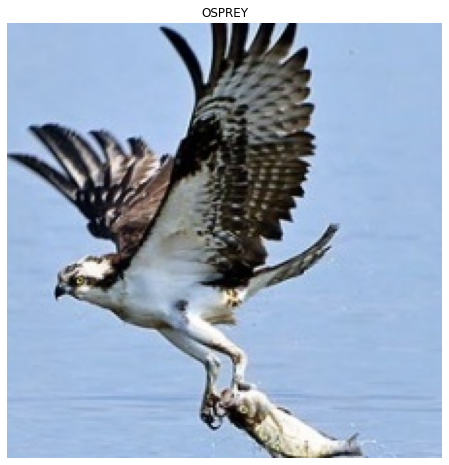

In [99]:
index = np.random.randint(0, num_images)
show_image(df, "data", index)

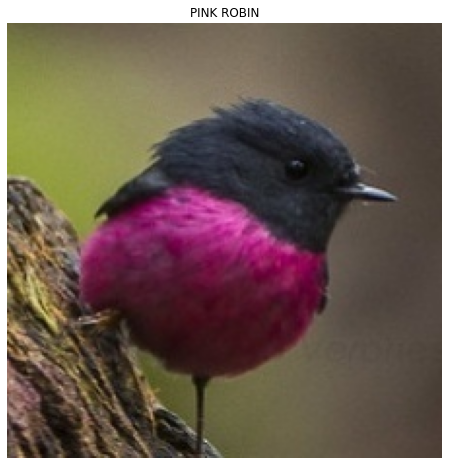

In [100]:
index = np.random.randint(0, num_images)
show_image(df, "data", index)

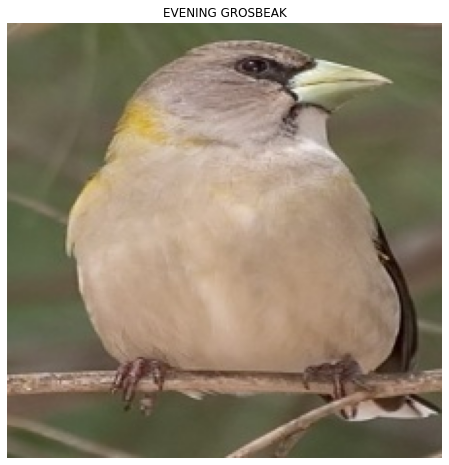

In [101]:
index = np.random.randint(0, num_images)
show_image(df, "data", index)

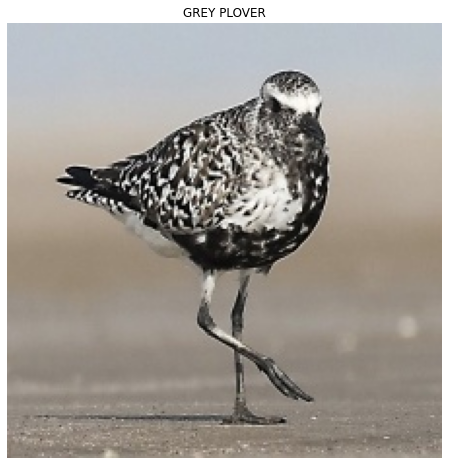

In [102]:
index = np.random.randint(0, num_images)
show_image(df, "data", index)

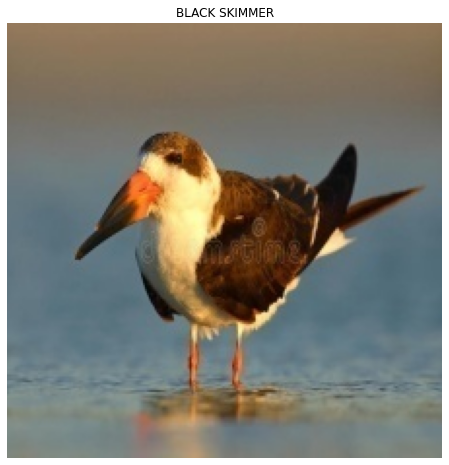

In [103]:
index = np.random.randint(0, num_images)
show_image(df, "data", index)

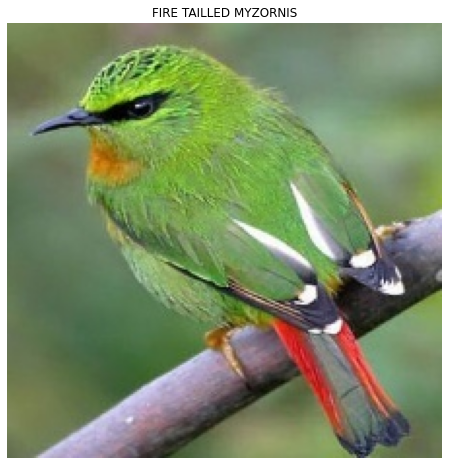

In [104]:
index = np.random.randint(0, num_images)
show_image(df, "data", index)

Let's now check the min and max values of the image pixel values. This is to ensure that the images are later in the range of [0, 1] and are not normalized twice.

In [105]:
def check_min_max_image(df, folder, index):
    filename = os.path.join(folder, df["filepaths"][index])
    
    image = plt.imread(filename)
    print(f"Min: {np.min(image)} | Max: {np.max(image)}")

In [106]:
index = np.random.randint(0, num_images)
check_min_max_image(df, "data", index)

Min: 0 | Max: 255


In [107]:
index = np.random.randint(0, num_images)
check_min_max_image(df, "data", index)

Min: 0 | Max: 255


In [108]:
index = np.random.randint(0, num_images)
check_min_max_image(df, "data", index)

Min: 0 | Max: 255


Okay the images are not already normalized, so we can do this later in the input pipeline.

### Check distribution of data
Let's now check the data distribution. This is to check if there are enough images for each class and to maybe apply some data imbalance strategies for balancing the dataset.

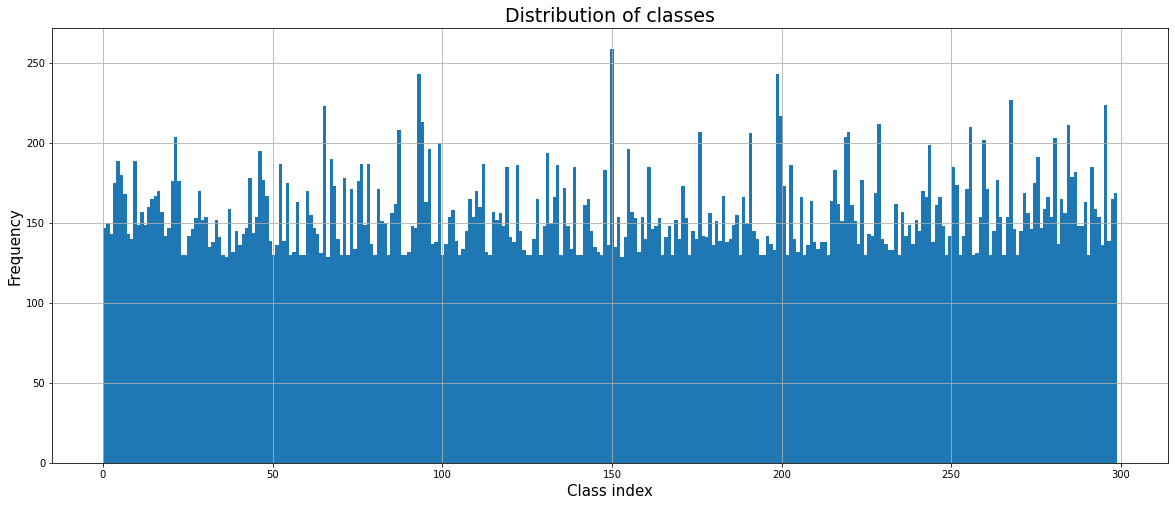

In [109]:
plt.figure(figsize=(20, 8))
df["class_index"].hist(bins=len(class_names))
plt.title("Distribution of classes", size=19)
plt.xlabel("Class index", size=15)
plt.ylabel("Frequency", size=15)
plt.show()

The dataset looks quite balanced. However, some classes seem to have less samples than others, which could result in a worse performance of the model on these classes. Let's later check if balancing can improve the overal performance! <br> <br>
Let's now check the distributions for the training and test set. This is important to ensure that the test set contains a similar distribution than the training set.

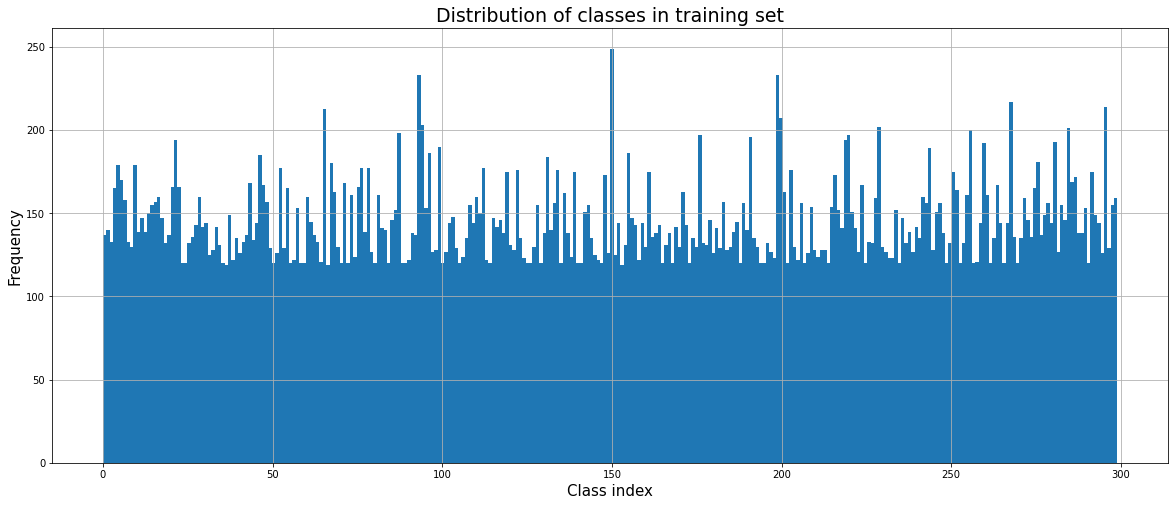

In [110]:
plt.figure(figsize=(20, 8))
df_train["class_index"].hist(bins=len(class_names))
plt.title("Distribution of classes in training set", size=19)
plt.xlabel("Class index", size=15)
plt.ylabel("Frequency", size=15)
plt.show()

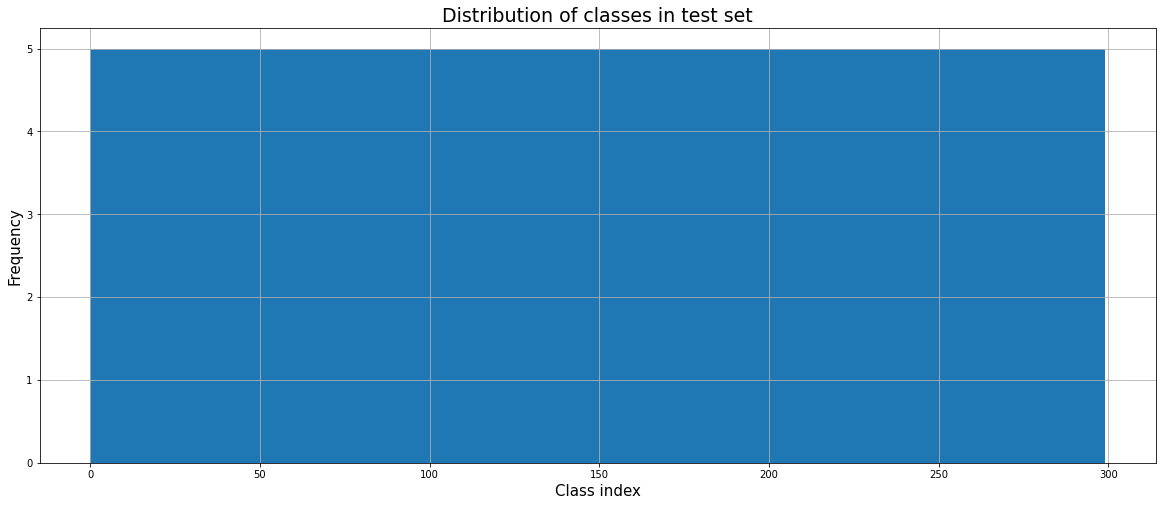

In [111]:
plt.figure(figsize=(20, 8))
df_test["class_index"].hist(bins=len(class_names))
plt.title("Distribution of classes in test set", size=19)
plt.xlabel("Class index", size=15)
plt.ylabel("Frequency", size=15)
plt.show()

Okay. Seems like the test set distribution was created manually and does not reflect the real data distribution. This is bad, because the test set would not reflect the performance on "real world" data. Therefore, let's create new training, validation and test sets by using the StratefiedShuffleSplit of sklearn.

In [124]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# split in train and test
for train_index, test_index in sss.split(df.drop(columns="labels"), df["class_index"]):
    print("TRAIN:", train_index, "TEST:", test_index)
    df_train = df.iloc[train_index]
    df_test = df.iloc[test_index]

TRAIN: [46048 33833 23091 ... 21793 30861 31113] TEST: [ 6071 26263 34658 ...  9546  9586 34243]


In [125]:
# split train in train and validation
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

df_train_tmp = df_train.copy()

for train_index, test_index in sss.split(df_train.drop(columns="labels"), df_train["class_index"]):
    print("TRAIN:", train_index, "TEST:", test_index)
    df_train = df_train_tmp.iloc[train_index]
    df_valid = df_train_tmp.iloc[test_index]

TRAIN: [10951 23489  7695 ... 15234 15269 22063] TEST: [27819  9728 24048 ...   325 14149 20626]


In [131]:
# quickly check if number of samples of train + valid + test still matches the total number of samples
assert df_train.shape[0] + df_valid.shape[0] + df_test.shape[0] == df.shape[0], "Number of samples in splits does not match"

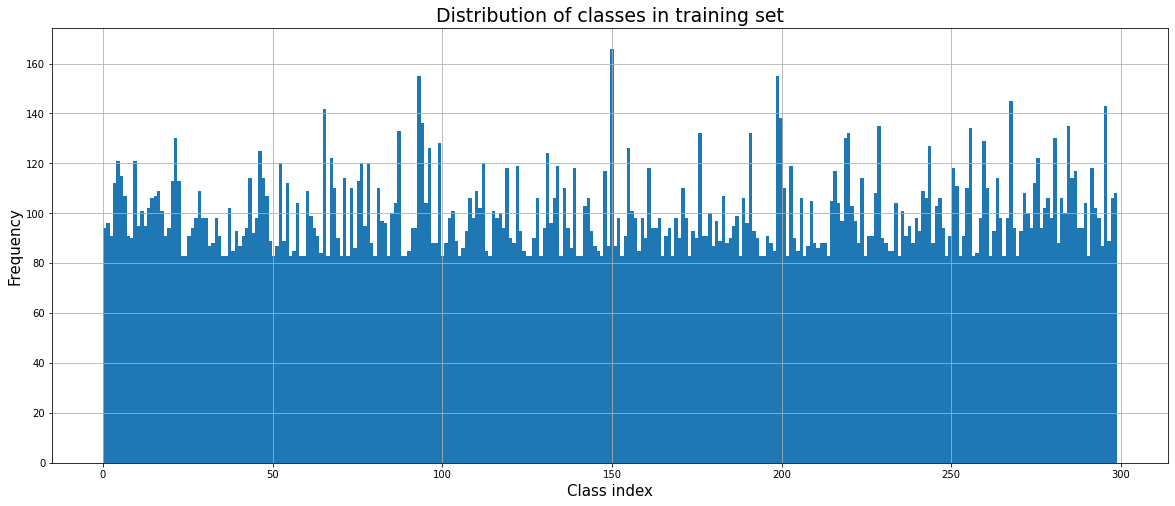

In [127]:
plt.figure(figsize=(20, 8))
df_train["class_index"].hist(bins=len(class_names))
plt.title("Distribution of classes in training set", size=19)
plt.xlabel("Class index", size=15)
plt.ylabel("Frequency", size=15)
plt.show()

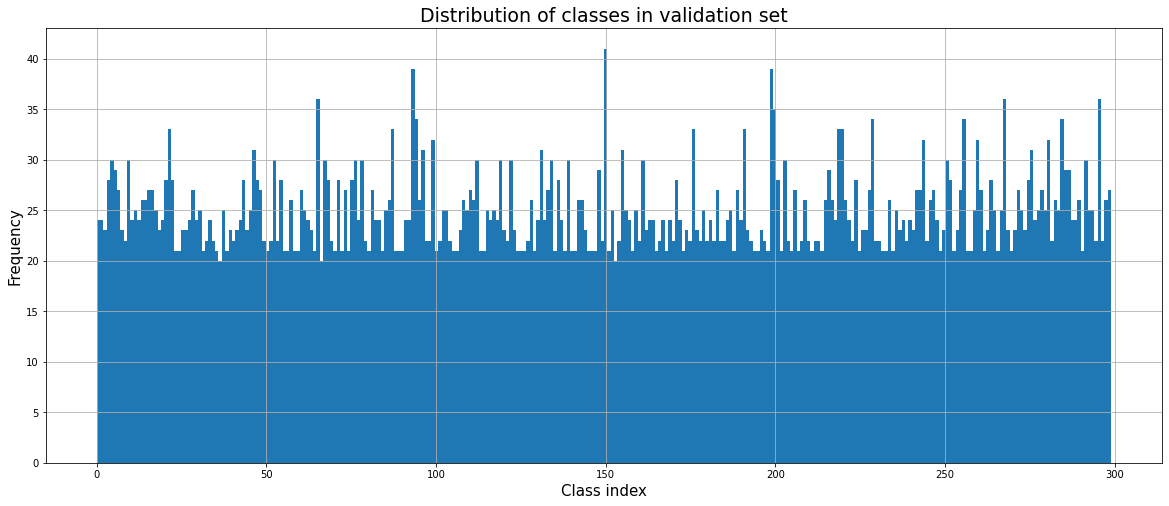

In [128]:
plt.figure(figsize=(20, 8))
df_valid["class_index"].hist(bins=len(class_names))
plt.title("Distribution of classes in validation set", size=19)
plt.xlabel("Class index", size=15)
plt.ylabel("Frequency", size=15)
plt.show()

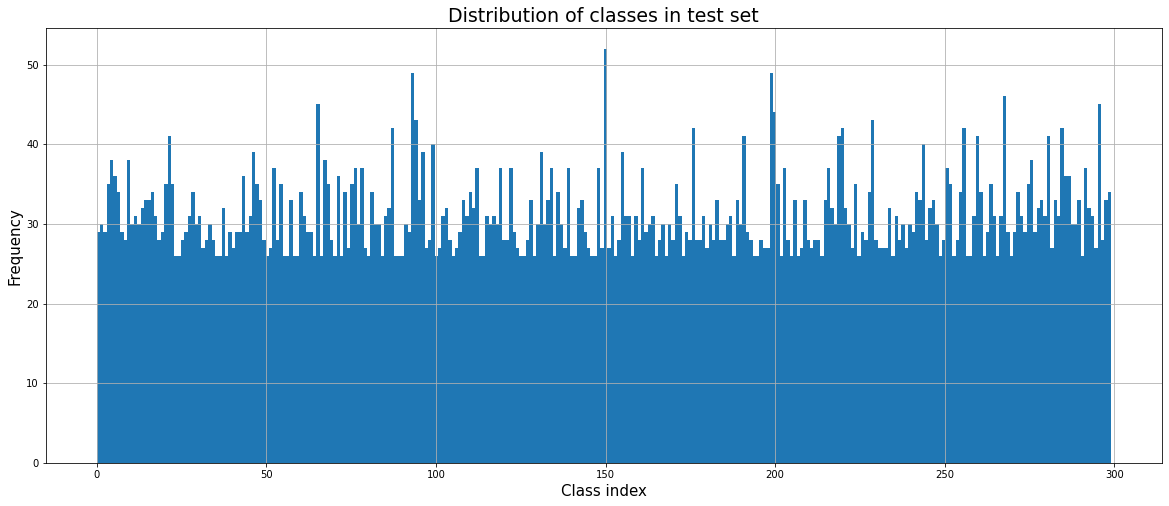

In [129]:
plt.figure(figsize=(20, 8))
df_test["class_index"].hist(bins=len(class_names))
plt.title("Distribution of classes in test set", size=19)
plt.xlabel("Class index", size=15)
plt.ylabel("Frequency", size=15)
plt.show()

Perfect! Now the distributions are all looking the same. Now we can start with creating the input pipeline for training the model.

## Create Tensorflow Input Pipeline

Let's first create a augmentation function that can be used by the image data generator. I selected the augmentations based on some experience and I applied them on an example image of the current dataset in the notebook "Check_Augmentations.ipynb". I directly started using these augmentations to prevent the models from quickly overfitting to the relatively small dataset. 

In [54]:
import imgaug.augmenters as iaa

def apply_augmentation(input_image):
    input_image = np.expand_dims(input_image, axis=0)
    aug_list = [
                iaa.Fliplr(1.0),
                iaa.Multiply((0.5, 1.5)),
                iaa.SaltAndPepper(0.1),
                [iaa.GammaContrast((0.8, 1.2)),iaa.Add((-60, 60))],
                iaa.AdditiveGaussianNoise(scale=(0, 0.2*255)),
                iaa.MotionBlur(k=15),
                iaa.Affine(scale=(0.5, 1.2)),
                iaa.Rotate((-45, 45)),
                iaa.ElasticTransformation(alpha=(50.0, 300.0), sigma=25.0),
              ]                
    for idx, aug in enumerate(aug_list):
        # only apply augmentation such that in total 10% of the images are not augmented
        # P_single_aug = 1 - exp((1/N) * ln(P_not_aug))
        rand_nr = np.random.rand()
        threshold = 0.21
        if isinstance(aug, list):
            rand_aug = np.random.randint(0, 2)
            input_image = np.clip(aug[rand_aug](images=input_image), 0., 255.) if rand_nr <= threshold else input_image
        else:
            input_image = np.clip(aug(images=input_image), 0., 255.) if rand_nr <= threshold else input_image

    return np.squeeze(input_image, axis=0)

In [55]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen_train = ImageDataGenerator(rescale=1./255, preprocessing_function=apply_augmentation)
datagen_val = ImageDataGenerator(rescale = 1. / 255)

In [130]:
# create datagenerators by calling flow_from_dataframe on them
path_to_images = r"data"
batch_size = 8
shuffle = True
target_size = (224, 224)

train_generator = datagen_train.flow_from_dataframe(dataframe=df_train, directory=path_to_images,
                                                    x_col="filepaths", y_col="class_index", 
                                                    batch_size=batch_size, shuffle=shuffle,
                                                    class_mode="raw", target_size=target_size, 
                                                    color_mode="rgb", seed=42)

valid_generator = datagen_val.flow_from_dataframe(dataframe=df_val, directory=path_to_images,
                                                    x_col="filepaths", y_col="class_index",  
                                                    batch_size=batch_size, shuffle=shuffle,
                                                    class_mode="raw", target_size=target_size, 
                                                    color_mode="rgb", seed=42)

steps_per_epoch_train = train_generator.__len__()
steps_per_epoch_val = valid_generator.__len__()

Found 29837 validated image filenames.
Found 1500 validated image filenames.


Now: Check the format in order to ensure that the images are valid when they are entered into the CNN.

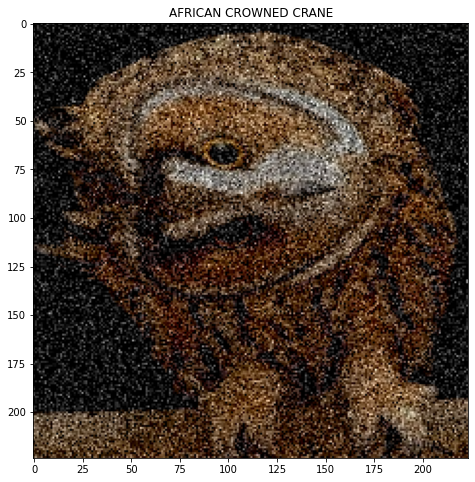

In [132]:
# get random batch and random image from batch
batch_nr = np.random.randint(0, steps_per_epoch_train)
random_img_nr = np.random.randint(0, batch_size)
image = train_generator[batch_nr][0][random_img_nr]
label = train_generator[batch_nr][1][random_img_nr]
plt.title(class_names[np.argmax(label)])
plt.imshow(image)

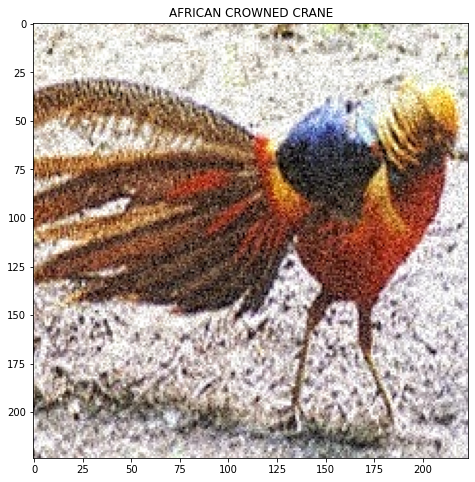

In [133]:
# get random batch and random image from batch
batch_nr = np.random.randint(0, steps_per_epoch_train)
random_img_nr = np.random.randint(0, batch_size)
image = train_generator[batch_nr][0][random_img_nr]
label = train_generator[batch_nr][1][random_img_nr]
plt.title(class_names[np.argmax(label)])
plt.imshow(image)

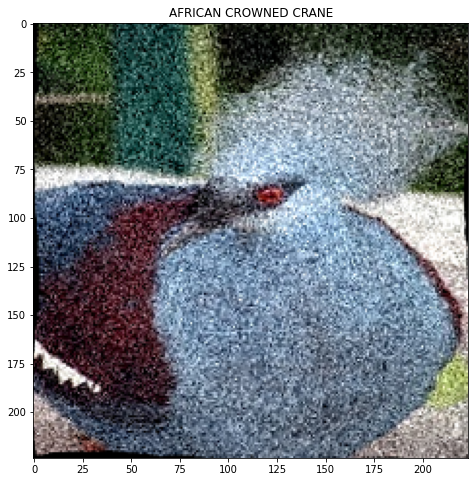

In [134]:
# get random batch and random image from batch
batch_nr = np.random.randint(0, steps_per_epoch_train)
random_img_nr = np.random.randint(0, batch_size)
image = train_generator[batch_nr][0][random_img_nr]
label = train_generator[batch_nr][1][random_img_nr]
plt.title(class_names[np.argmax(label)])
plt.imshow(image)

Let's now build a keras model factory to try out different cnns and use the best performing by considering the trade off between performance and complexity.

In [135]:
class KerasModelFactory():
    '''
    This class can be used to create a keras model and return it.
    '''
    
    def __init__(self):
        '''
        Constructor...
        '''
        pass
    
    def create_and_return_keras_model(self, model_name, num_classes, input_shape, 
                                      activation_func="softmax", transfer_learning=False):
        '''
        This function takes some information about the keras model to create and returns it. The model_name must be one
        of the following: ["efficientnetb0", "xception", "densenet121", "resnet18", "resnet34"]
        
        Args:
            model_name (str): Name of the keras model which shall be instantiated.
            num_classes (int): The number of classes and therefore the number of output neurons.
            input_shape (tuple): Shape of input images (height, widht, depth)
            activation_func (str): Activation function that should be used on the output layer
            transfer_learning (bool): Whether to reuse the trained weights on the imagenet dataset 
                                         or to use newly initialized weights
        '''
        if (not isinstance(model_name, str)):
                raise ValueError("Input model_name has the wrong datatype!")
        
        if not isinstance(num_classes, int):
            raise ValueError("Input num_classes has the wrong datatype!")
        
        if not isinstance(transfer_learning, bool):
            raise ValueError("Input transfer_leraning has the wrong datatype!")
        
        if not isinstance(activation_func, str):
            raise ValueError("Input activation_func has the wrong datatype!")
        
        weights = "imagenet" if transfer_learning else None
        
        if model_name == "efficientnetb0":
            from tensorflow.keras.applications import EfficientNetB0
            model = EfficientNetB0(weights=weights, include_top=False, input_shape=input_shape)
        elif model_name == "efficientnetb2":
            from tensorflow.keras.applications import EfficientNetB2
            model = EfficientNetB2(weights=weights, include_top=False, input_shape=input_shape)
        elif model_name == "xception":
            from tensorflow.keras.applications import Xception
            model = Xception(weights=weights, include_top=False, input_shape=input_shape)
        else:
            from classification_models.tfkeras import Classifiers
            net, _ = Classifiers.get(model_name)
            model = net(input_shape=input_shape, weights=weights, include_top=False)
            
        # add a global spatial average pooling layer
        # this helps to decrease the risk of overfitting and to plot class activation maps
        x = model.output
        x = keras.layers.GlobalAveragePooling2D()(x)

        # and a fully connected output/classification layer
        predictions = keras.layers.Dense(num_classes, activation=activation_func)(x)

        # create the full network so we can train on it
        model = keras.models.Model(inputs=model.input, outputs=predictions)
        
        return model

In [136]:
# test keras factory
factory = KerasModelFactory()

Let's now compare different cnn encoders and choose the best one by considering the number of trainable parameters and the performance on the validation set. <br>
A cross-validation would be good for choosing the models. However, I decided to not use a cross validation in order to speed up the training process a little bit. <br> <br>
Steps for training the different encoders:
1. Train encoder for 40 epochs and store best validation f1-score of the encoder.
2. Create a plot with trainable parameters on x-axis and best score on y-axis. 
3. Use plot to decide which cnn architecture to use.

In [137]:
encoder_list = ["efficientnetb0", "xception", "densenet121", "resnet18", "resnet34", "resnet50"]
num_epochs = 40
results_dict = dict()
results_hists_dict = dict()
img_height, img_width = target_size
img_depth = 3

for encoder in encoder_list:
    print(f"Start training {encoder}...")
    model = factory.create_and_return_keras_model(encoder, 
                                              num_classes=len(class_names), 
                                              input_shape=(img_height, img_width, img_depth),
                                              activation_func="softmax",
                                              transfer_learning=True)
    
    opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

    # define the metrics
    metrics_list = [
        tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
        tf.keras.metrics.AUC(name="auc"),
        tfa.metrics.F1Score(num_classes=len(class_names), average='weighted',threshold=0.5),
    ]

    # compile the model
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=metrics_list)
    
    # fit the model for num_epochs epochs
    with tf.device("/GPU:0"):
        hist_dict = model.fit(train_generator, epochs=num_epochs, verbose=1, validation_data=valid_generator)
    
    # get the maximum validation f1-score and validation accuracy and store them
    results_dict[encoder] = [np.max(hist_dict.history["val_f1_score"]), np.max(hist_dict.history["val_accuracy"])]
    
    # save also the history in order to make some nice visualizations
    results_hists_dict[encoder] = hist_dict.history

Start training efficientnetb0...
Epoch 1/40


ValueError: in user code:

    C:\Users\brusp\.conda\envs\ml\lib\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    C:\Users\brusp\.conda\envs\ml\lib\site-packages\keras\engine\training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\brusp\.conda\envs\ml\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\brusp\.conda\envs\ml\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\brusp\.conda\envs\ml\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\brusp\.conda\envs\ml\lib\site-packages\keras\engine\training.py:835 run_step  **
        outputs = model.train_step(data)
    C:\Users\brusp\.conda\envs\ml\lib\site-packages\keras\engine\training.py:788 train_step
        loss = self.compiled_loss(
    C:\Users\brusp\.conda\envs\ml\lib\site-packages\keras\engine\compile_utils.py:201 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\brusp\.conda\envs\ml\lib\site-packages\keras\losses.py:141 __call__
        losses = call_fn(y_true, y_pred)
    C:\Users\brusp\.conda\envs\ml\lib\site-packages\keras\losses.py:245 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\brusp\.conda\envs\ml\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\brusp\.conda\envs\ml\lib\site-packages\keras\losses.py:1665 categorical_crossentropy
        return backend.categorical_crossentropy(
    C:\Users\brusp\.conda\envs\ml\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\brusp\.conda\envs\ml\lib\site-packages\keras\backend.py:4839 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    C:\Users\brusp\.conda\envs\ml\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1161 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 1) and (None, 300) are incompatible


In [173]:
def create_accuracy_plots(results_hists_dict, figpath=r"figures\encoder_search_accuracy.pdf",
                          num_rows=2, num_cols=3):
    '''
    This function takes the dictionary with all training histories of the different encoders 
    and creates an accuracy plot.
    
    Args:
        results_hists_dict (dictionary): Dictionary with encoder name as key and the training history dict as value
        figpath (string): Path where the figure should be stored
        num_rows (int): Number of rows in subplot figure
        num_cols (int): Number of columns in subplot figure
    '''
    fig = plt.figure(figsize = (16, 8))
    
    # loop over different encoders and plot results
    for idx, (key, hist_dict) in enumerate(results_hists_dict.items()):
        plt.subplot(num_rows, num_cols, idx+1)
        plt.plot(hist_dict["accuracy"], label="Train")
        plt.plot(hist_dict["val_accuracy"], label="Val")
        
        if(idx >= num_cols):
            plt.xlabel("Epoch")
            
        if(idx == 0 or idx == num_cols):
            plt.ylabel("Accuracy")
        plt.title(f"{key}")
        plt.legend(loc="lower right")
    
    plt.tight_layout()
    plt.savefig(figpath)
    plt.show()

In [174]:
def create_loss_plots(results_hists_dict, figpath=r"figures\encoder_search_loss.pdf",
                      num_rows=2, num_cols=3):
    '''
    This function takes the dictionary with all training histories of the different encoders 
    and creates a loss plot.
    
    Args:
        results_hists_dict (dictionary): Dictionary with encoder name as key and the training history dict as value
        figpath (string): Path where the figure should be stored
        num_rows (int): Number of rows in subplot figure
        num_cols (int): Number of columns in subplot figure
    '''
    fig = plt.figure(figsize = (16, 8))
    
    # loop over different encoders and plot results
    for idx, (key, hist_dict) in enumerate(results_hists_dict.items()):
        plt.subplot(num_rows, num_cols, idx+1)
        plt.plot(hist_dict["loss"], label="Train")
        plt.plot(hist_dict["val_loss"], label="Val")
        
        if(idx >= num_cols):
            plt.xlabel("Epoch")
            
        if(idx == 0 or idx == num_cols):
            plt.ylabel("Loss")
        plt.title(f"{key}")
        plt.legend(loc="lower right")
    
    plt.tight_layout()
    plt.savefig(figpath)
    plt.show()

In [175]:
def create_f1_plots(results_hists_dict, figpath=r"figures\encoder_search_f1_score.pdf",
                    num_rows=2, num_cols=3):
    '''
    This function takes the dictionary with all training histories of the different encoders 
    and creates a f1-score plot.
    
    Args:
        results_hists_dict (dictionary): Dictionary with encoder name as key and the training history dict as value
        figpath (string): Path where the figure should be stored
        num_rows (int): Number of rows in subplot figure
        num_cols (int): Number of columns in subplot figure
    '''
    fig = plt.figure(figsize = (16, 8))
    
    # loop over different encoders and plot results
    for idx, (key, hist_dict) in enumerate(results_hists_dict.items()):
        plt.subplot(num_rows, num_cols, idx+1)
        plt.plot(hist_dict["f1_score"], label="Train")
        plt.plot(hist_dict["val_f1_score"], label="Val")
        
        if(idx >= num_cols):
            plt.xlabel("Epoch")
            
        if(idx == 0 or idx == num_cols):
            plt.ylabel("F1-Score")
        plt.title(f"{key}")
        plt.legend(loc="lower right")
    
    plt.tight_layout()
    plt.savefig(figpath)
    plt.show()

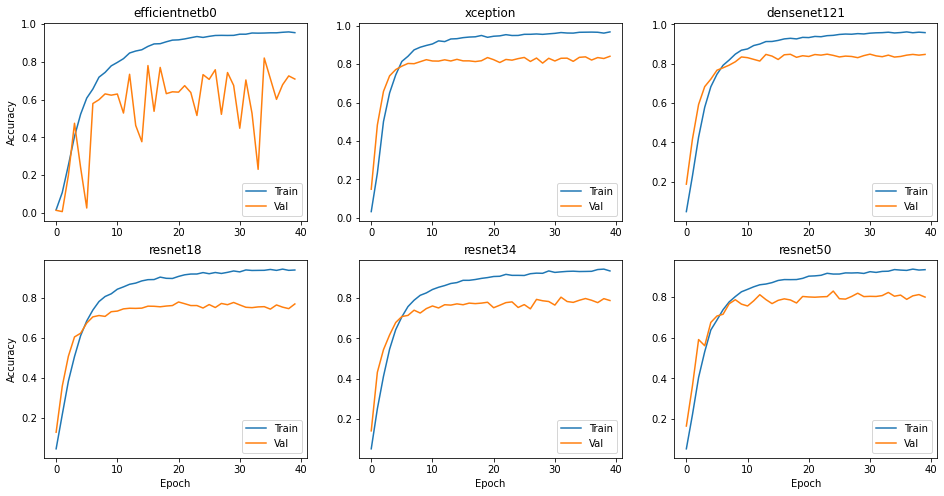

In [62]:
create_accuracy_plots(results_hists_dict)

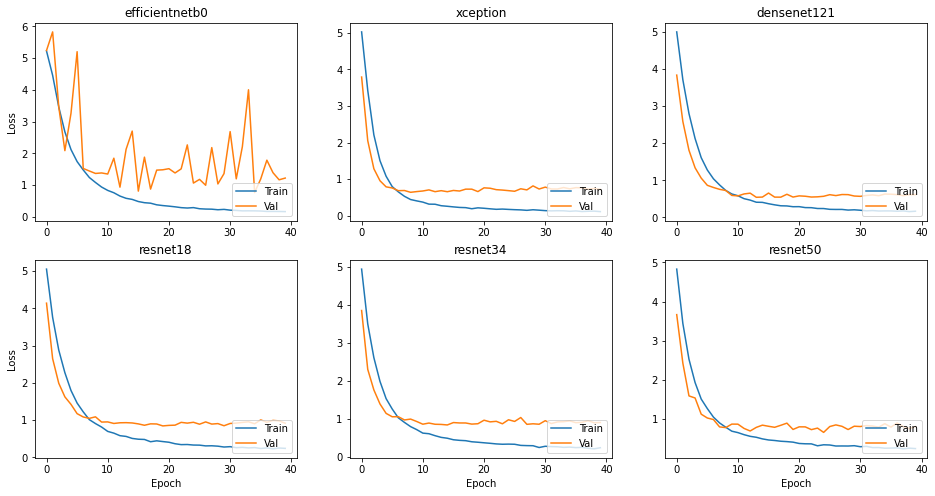

In [63]:
create_loss_plots(results_hists_dict)

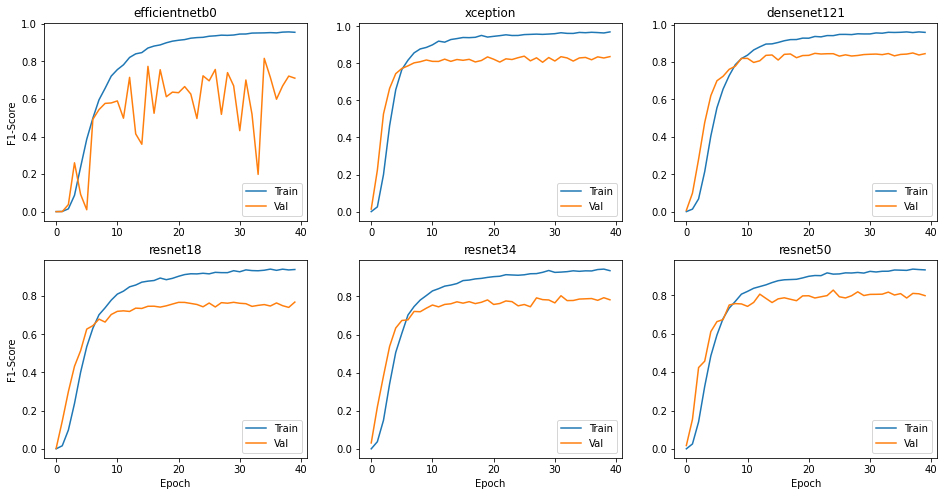

In [64]:
create_f1_plots(results_hists_dict)

In [58]:
(pd.DataFrame
 .from_dict(results_dict, orient="index", columns=["best_val_f1_score", "best_val_accuracy"])
 .sort_values(by=["best_val_f1_score"], ascending=False))

best_val_f1_score  best_val_accuracy
densenet121              0.848489           0.848987
xception                 0.838862           0.841007
resnet50                 0.827261           0.827502
efficientnetb0           0.816388           0.819521
resnet34                 0.803719           0.803560
resnet18                 0.768697           0.777778

The DenseNet121 achieved the best f1-score and accuracy and is therefore used as the baseline encoder architecture for the remaining part of this project! <br>
By looking at these curves, one can see that there happened some overfitting (gap between validation and training curves). Let's later see if we can fix this!

As a next step, the network shall be trained with different image sizes in order to find the best image size. 

In [77]:
list_image_sizes = [(128, 128), (192, 192), (224, 224), (256, 256)]
num_epochs = 30
encoder = "densenet121"
path_to_images = r"data\car_ims"
batch_size = 8
depth = 3 # using rgb
shuffle = True
img_size_results_dict = dict()
img_size_hists_dict = dict()

for target_size in list_image_sizes:
    print(f"Start training with target size of {target_size}...")
    img_height, img_width = target_size
    
    # setup input pipeline
    datagen_train = ImageDataGenerator(rescale=1./255,preprocessing_function=apply_augmentation)
    datagen_val = ImageDataGenerator(rescale = 1. / 255)
    
    train_generator = datagen_train.flow_from_dataframe(dataframe=df_train, directory=path_to_images,
                                                        x_col="filename", y_col=df_train.columns[2:], 
                                                        batch_size=batch_size, shuffle=shuffle,
                                                        class_mode="raw", target_size=target_size, 
                                                        color_mode="rgb", seed=42)

    valid_generator = datagen_val.flow_from_dataframe(dataframe=df_val, directory=path_to_images,
                                                        x_col="filename", y_col=df_val.columns[2:], 
                                                        batch_size=batch_size, shuffle=shuffle,
                                                        class_mode="raw", target_size=target_size, 
                                                        color_mode="rgb", seed=42)
    
    model = factory.create_and_return_keras_model(encoder, 
                                                  num_classes=len(class_names), 
                                                  input_shape=(img_height, img_width, depth),
                                                  activation_func="softmax",
                                                  transfer_learning=True)
    
    opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

    # define the metrics
    metrics_list = [
        tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
        tf.keras.metrics.AUC(name="auc"),
        tfa.metrics.F1Score(num_classes=len(class_names), average='weighted',threshold=0.5),
    ]

    # compile the model
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=metrics_list)
    
    # fit the model for num_epochs epochs
    with tf.device("/GPU:0"):
        hist_dict = model.fit(train_generator, epochs=num_epochs, verbose=1, validation_data=valid_generator)
    
    # get the maximum validation f1-score and validation accuracy and store them
    img_size_results_dict[target_size] = [np.max(hist_dict.history["val_f1_score"]), 
                                          np.max(hist_dict.history["val_accuracy"])]
    
    # add history 
    img_size_hists_dict[target_size] = hist_dict.history

Start training with target size of (128, 128)...
Found 6515 validated image filenames.
Found 1629 validated image filenames.
Epoch 1/30
815/815 [==============================] - 242s 286ms/step - loss: 5.6944 - accuracy: 0.0093 - auc: 0.5280 - f1_score: 0.0000e+00 - val_loss: 5.0136 - val_accuracy: 0.0485 - val_auc: 0.6772 - val_f1_score: 0.0021
Epoch 2/30
815/815 [==============================] - 233s 286ms/step - loss: 4.8000 - accuracy: 0.0595 - auc: 0.7106 - f1_score: 0.0016 - val_loss: 3.9906 - val_accuracy: 0.1381 - val_auc: 0.8403 - val_f1_score: 0.0341
Epoch 3/30
815/815 [==============================] - 228s 280ms/step - loss: 4.0586 - accuracy: 0.1485 - auc: 0.8365 - f1_score: 0.0096 - val_loss: 3.2482 - val_accuracy: 0.2492 - val_auc: 0.9104 - val_f1_score: 0.0857
Epoch 4/30
815/815 [==============================] - 233s 285ms/step - loss: 3.3929 - accuracy: 0.2508 - auc: 0.9071 - f1_score: 0.0464 - val_loss: 2.8327 - val_accuracy: 0.3106 - val_auc: 0.9327 - val_f1_score

Epoch 7/30
815/815 [==============================] - 252s 309ms/step - loss: 1.3215 - accuracy: 0.7193 - auc: 0.9909 - f1_score: 0.5476 - val_loss: 1.1307 - val_accuracy: 0.6918 - val_auc: 0.9871 - val_f1_score: 0.6313
Epoch 8/30
815/815 [==============================] - 252s 309ms/step - loss: 1.1170 - accuracy: 0.7591 - auc: 0.9929 - f1_score: 0.6372 - val_loss: 0.9421 - val_accuracy: 0.7440 - val_auc: 0.9919 - val_f1_score: 0.7039
Epoch 9/30
815/815 [==============================] - 251s 307ms/step - loss: 0.9370 - accuracy: 0.8000 - auc: 0.9935 - f1_score: 0.6978 - val_loss: 0.9446 - val_accuracy: 0.7446 - val_auc: 0.9903 - val_f1_score: 0.7013
Epoch 10/30
815/815 [==============================] - 251s 308ms/step - loss: 0.8089 - accuracy: 0.8298 - auc: 0.9949 - f1_score: 0.7562 - val_loss: 0.9201 - val_accuracy: 0.7477 - val_auc: 0.9866 - val_f1_score: 0.7159
Epoch 11/30
815/815 [==============================] - 252s 309ms/step - loss: 0.7538 - accuracy: 0.8369 - auc: 0.9952 

815/815 [==============================] - 276s 339ms/step - loss: 0.2808 - accuracy: 0.9394 - auc: 0.9991 - f1_score: 0.9274 - val_loss: 0.5574 - val_accuracy: 0.8619 - val_auc: 0.9901 - val_f1_score: 0.8431
Epoch 20/30
815/815 [==============================] - 273s 335ms/step - loss: 0.2770 - accuracy: 0.9403 - auc: 0.9987 - f1_score: 0.9278 - val_loss: 0.5644 - val_accuracy: 0.8471 - val_auc: 0.9916 - val_f1_score: 0.8406
Epoch 21/30
815/815 [==============================] - 271s 333ms/step - loss: 0.2545 - accuracy: 0.9459 - auc: 0.9990 - f1_score: 0.9381 - val_loss: 0.5781 - val_accuracy: 0.8410 - val_auc: 0.9922 - val_f1_score: 0.8403
Epoch 22/30
815/815 [==============================] - 266s 326ms/step - loss: 0.2396 - accuracy: 0.9488 - auc: 0.9991 - f1_score: 0.9411 - val_loss: 0.5714 - val_accuracy: 0.8373 - val_auc: 0.9913 - val_f1_score: 0.8280
Epoch 23/30
815/815 [==============================] - 275s 337ms/step - loss: 0.2527 - accuracy: 0.9415 - auc: 0.9988 - f1_scor

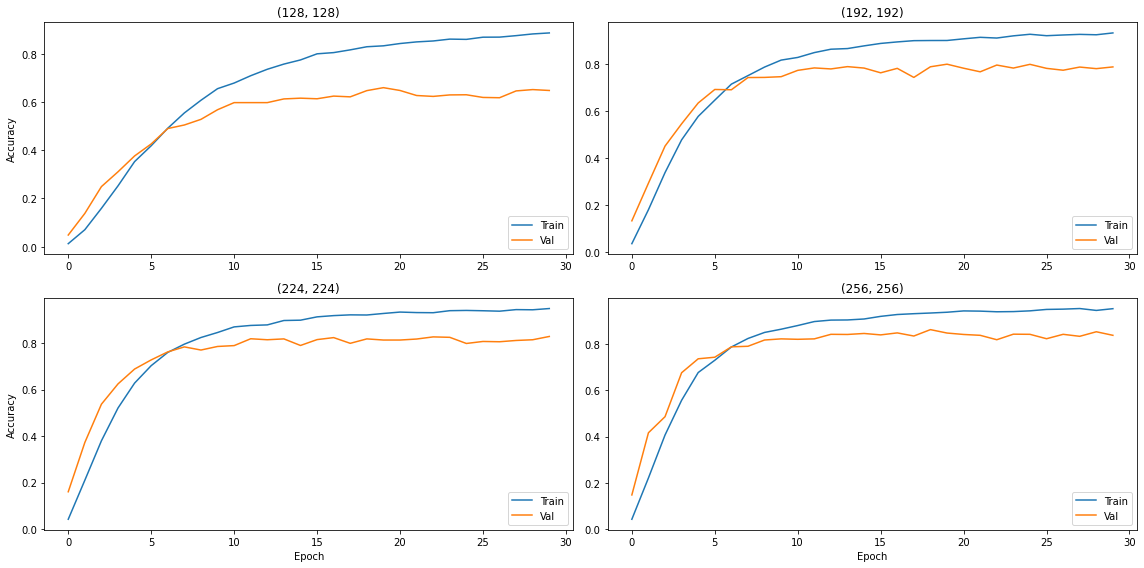

In [176]:
create_accuracy_plots(img_size_hists_dict, figpath=r"figures\image_size_results_accuracy.pdf", 
                      num_rows=2, num_cols=2)

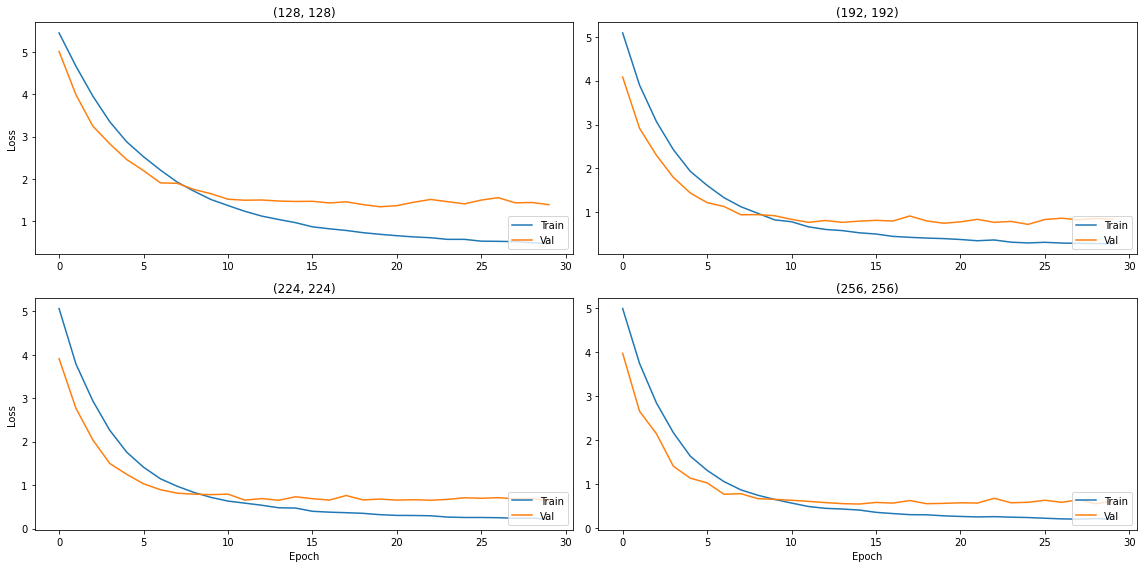

In [177]:
create_loss_plots(img_size_hists_dict, figpath=r"figures\image_size_results_loss.pdf", 
                      num_rows=2, num_cols=2)

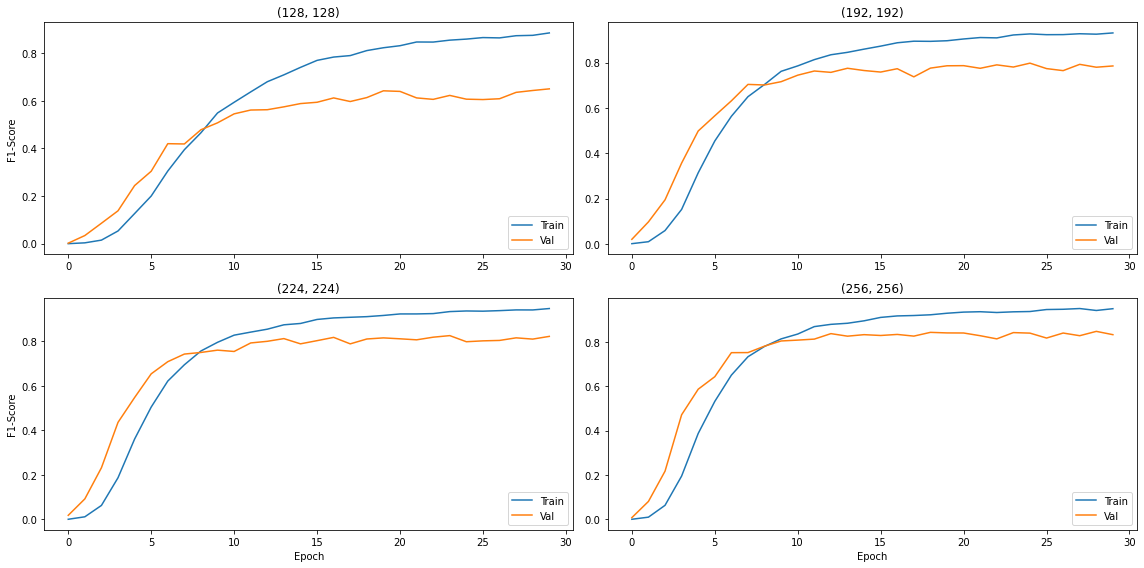

In [178]:
create_f1_plots(img_size_hists_dict, figpath=r"figures\image_size_results_f1_score.pdf", 
                      num_rows=2, num_cols=2)

In [85]:
(pd.DataFrame
 .from_dict(img_size_results_dict, orient="index", columns=["best_val_f1_score", "best_val_accuracy"])
 .sort_values(by=["best_val_f1_score"], ascending=False))

best_val_f1_score  best_val_accuracy
(256, 256)           0.847612           0.861878
(224, 224)           0.824984           0.828115
(192, 192)           0.797760           0.801105
(128, 128)           0.649851           0.659300

As one would have guessed: The larger the images, the better the performance of the model. From image size 192x192 to 256x256, there is still a 5% increase in accuracy. And in my case, it's not that important to save some computation power and space of the model. Therefore, I decided to choose the image size of 256x256 pixels for further processing! <br><br> 
Perfect. Now we also have our optimal image size. Let's now continue and check whether we should apply some oversampling to balance the dataset or not. <br> <br>
Important: Oversampling should only be applied on the training set and not on the overal dataset! This is to ensure that no images of the training set are also in the validation or even worse in the test set!

In [86]:
def oversample_dataframe(df):
    # create copy of dataframe
    df_copy = df.copy()
    
    # find majortiy class count
    count_majority = df_copy[df_copy.columns[2:]].sum().max()
    
    # loop over all classes and oversample until count_majority number of samples are reached
    balanced_columns_list = list()
    for col in df_copy.columns[2:]:
        # create a smaller dataframe only containing the rows with images of the current class
        df_class_1 = df_copy[df_copy[col] == 1]
        # get the number of samples within that class
        count_class_1 = df_class_1.shape[0]
        
        # copy samples from current class until as many samples as in majority class are reached and store them in a dataframe
        df_oversampled = df_class_1.sample(count_majority - count_class_1, replace=True)
        
        # add new oversampled data to initial data and add to list of new dataframe columns
        balanced_columns_list.append(pd.concat([df_class_1, df_oversampled]))
    
    # concatenate all dataframes togehter to get the final one
    final_dataframe = pd.concat(balanced_columns_list)
    
    return final_dataframe

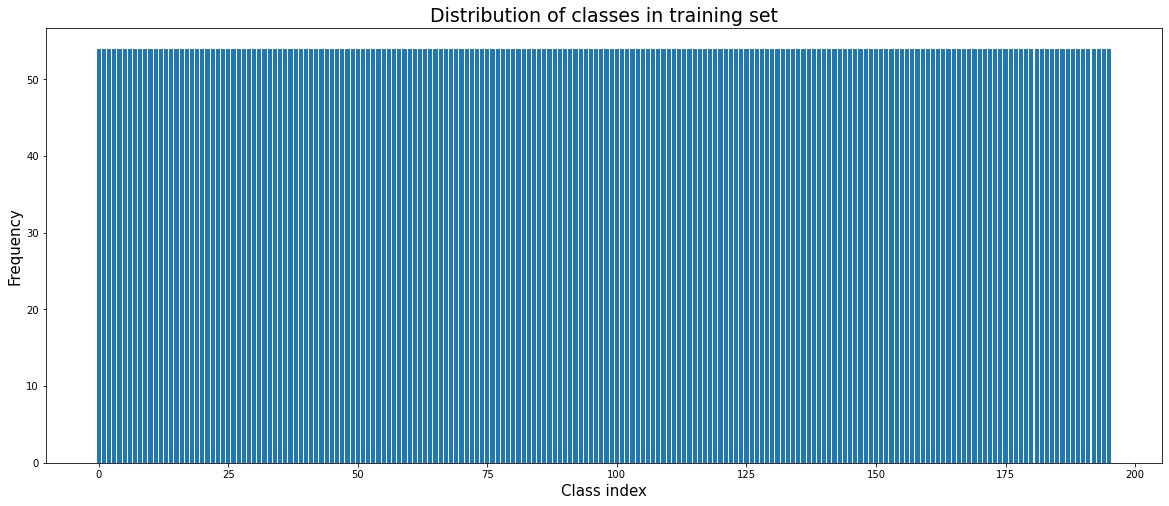

In [89]:
df_train_oversampled = oversample_dataframe(df_train)

plt.figure(figsize=(20, 8))
count_classes_train = df_train_oversampled[class_names].sum(axis=0).values
bins = np.arange(0, len(class_names))
plt.bar(x=bins, height=count_classes_train)
plt.title("Distribution of classes in training set", size=19)
plt.xlabel("Class index", size=15)
plt.ylabel("Frequency", size=15)
plt.savefig(r"figures\oversampled_dataset.pdf")
plt.show()

That looks good. Now we have a fully balanced dataframe. Let's now create the training loop for comparing the fully balanced to the imbalanced training. <br> 
We only have to train the oversampling case, because we can reuse the results from the network with our new target image size as the results for the imbalanced learning.

In [92]:
target_image_size = (256, 256)
img_height, img_width = target_image_size
num_epochs = 30
encoder = "densenet121"
path_to_images = r"data\car_ims"
batch_size = 8
depth = 3 # using rgb
oversampling_results = list()

# setup input pipeline
datagen_train = ImageDataGenerator(rescale=1./255,preprocessing_function=apply_augmentation)
datagen_val = ImageDataGenerator(rescale = 1. / 255)

train_generator = datagen_train.flow_from_dataframe(dataframe=df_train_oversampled, directory=path_to_images,
                                                    x_col="filename", y_col=df_train_oversampled.columns[2:], 
                                                    batch_size=batch_size, shuffle=shuffle,
                                                    class_mode="raw", target_size=target_size, 
                                                    color_mode="rgb", seed=42)

valid_generator = datagen_val.flow_from_dataframe(dataframe=df_val, directory=path_to_images,
                                                    x_col="filename", y_col=df_val.columns[2:], 
                                                    batch_size=batch_size, shuffle=shuffle,
                                                    class_mode="raw", target_size=target_size, 
                                                    color_mode="rgb", seed=42)

model = factory.create_and_return_keras_model(encoder, 
                                              num_classes=len(class_names), 
                                              input_shape=(img_height, img_width, depth),
                                              activation_func="softmax",
                                              transfer_learning=True)

opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

# define the metrics
metrics_list = [
    tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
    tf.keras.metrics.AUC(name="auc"),
    tfa.metrics.F1Score(num_classes=len(class_names), average='weighted',threshold=0.5),
]

# compile the model
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=metrics_list)

# fit the model for num_epochs epochs
with tf.device("/GPU:0"):
    hist_dict = model.fit(train_generator, epochs=num_epochs, verbose=1, validation_data=valid_generator)

# get the maximum validation f1-score and validation accuracy and store them
oversampling_results = [np.max(hist_dict.history["val_f1_score"]), 
                        np.max(hist_dict.history["val_accuracy"])]

Found 10584 validated image filenames.
Found 1629 validated image filenames.
Epoch 1/30
1323/1323 [==============================] - 453s 335ms/step - loss: 5.1361 - accuracy: 0.0490 - auc: 0.6308 - f1_score: 0.0010 - val_loss: 3.1418 - val_accuracy: 0.3008 - val_auc: 0.9377 - val_f1_score: 0.0549
Epoch 2/30
1323/1323 [==============================] - 439s 332ms/step - loss: 3.0813 - accuracy: 0.3849 - auc: 0.9476 - f1_score: 0.0466 - val_loss: 1.7869 - val_accuracy: 0.5672 - val_auc: 0.9838 - val_f1_score: 0.3480
Epoch 3/30
1323/1323 [==============================] - 437s 330ms/step - loss: 1.9232 - accuracy: 0.6320 - auc: 0.9856 - f1_score: 0.2710 - val_loss: 1.2449 - val_accuracy: 0.7017 - val_auc: 0.9882 - val_f1_score: 0.5538
Epoch 4/30
1323/1323 [==============================] - 439s 332ms/step - loss: 1.2481 - accuracy: 0.7677 - auc: 0.9931 - f1_score: 0.5549 - val_loss: 0.9153 - val_accuracy: 0.7673 - val_auc: 0.9914 - val_f1_score: 0.7122
Epoch 5/30
1323/1323 [=============

In [93]:
print(f"Oversampling f1-score: {oversampling_results[0]} | Oversampling accuracy: {oversampling_results[1]}")

Oversampling f1-score: 0.8456816077232361 | Oversampling accuracy: 0.8434622287750244


Okay. Seems like oversampling doesn't bring any boost here. It only increases the training time per epoch. Therefore, I am not going to use oversampling for the final model! <br> <br>
Now let's come to the last evaluation step: Searching good hyperparameters using Bayesian Hyperparameter search.

In [106]:
import skopt
from skopt import gbrt_minimize, gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer  
from skopt.callbacks import CheckpointSaver

In [107]:
# create hyperparameter search space

dim_learning_rate = Real(low=1e-5, high=1e-3, prior='log-uniform', name='learning_rate')
dim_batch_size = Categorical([8, 16], name='batch_size')
dim_optimizer = Categorical(categories=["Adam", "RMSProp"], name="optimizer")
dim_decay = Real(low=0.95, high=1, name="decay_rate")
dim_steps_multiplier = Real(low=1, high=3, name="decay_steps")

dimensions = [dim_learning_rate,
              dim_batch_size,
              dim_optimizer,
              dim_decay,
              dim_steps_multiplier]

default_parameters = [[1e-4, 16, "Adam", 1, 3],
                      [1e-3, 16, "Adam", 0.95, 3],
                      [1e-4, 16, "RMSProp", 1, 3],
                      [1e-3, 16, "RMSProp", 0.95, 3]
                     ]

In [108]:
# let's write a create model function to easily return the keras model with all required parameters and setup

def create_model(learning_rate, optimizer, decay_rate, decay_steps, steps_per_epoch_train, encoder, new_class_names):
    
    model = factory.create_and_return_keras_model(encoder, 
                                                  num_classes=len(class_names), 
                                                  input_shape=(256, 256, 3),
                                                  activation_func="softmax",
                                                  transfer_learning=True)

    initial_learning_rate = learning_rate
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                                                                 decay_steps= int(decay_steps * steps_per_epoch_train),
                                                                 decay_rate=decay_rate,
                                                                 staircase=True)
        
    if optimizer == "RMSProp":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule,
                                                       rho=0.9, momentum=0.9, name="RMSprop")
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, name="Adam")
        
    # define the metrics
    metrics_list = [
        tf.keras.metrics.CategoricalAccuracy(),
        keras.metrics.AUC(name='auc'),
        tfa.metrics.F1Score(num_classes=len(class_names), average='weighted',threshold=0.5),
    ]

    # compile the model
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=metrics_list)
    
    return model

In [118]:
# let's now create the fitness function that shall be optimized

def create_fitness_func(encoder, class_names, num_epochs):

    @use_named_args(dimensions=dimensions)
    def fitness(learning_rate, batch_size, optimizer, decay_rate, decay_steps):
        
        print(f"Start with evaluating: lr: {learning_rate} | batch size: {batch_size} | optimizer: {optimizer} \
        decay rate: {decay_rate} | decay steps: {decay_steps}")
        
        # create data generators in order to load the images
        datagen_train = ImageDataGenerator(rescale=1./255,preprocessing_function=apply_augmentation)
        datagen_val = ImageDataGenerator(rescale = 1. / 255)

        train_generator = datagen_train.flow_from_dataframe(dataframe=df_train, directory=path_to_images,
                                                            x_col="filename", y_col=df_train.columns[2:], 
                                                            batch_size=batch_size, shuffle=shuffle,
                                                            class_mode="raw", target_size=target_size, 
                                                            color_mode="rgb", seed=42)

        valid_generator = datagen_val.flow_from_dataframe(dataframe=df_val, directory=path_to_images,
                                                            x_col="filename", y_col=df_val.columns[2:], 
                                                            batch_size=batch_size, shuffle=shuffle,
                                                            class_mode="raw", target_size=target_size, 
                                                            color_mode="rgb", seed=42)

        # set parameters for learning
        steps_per_epoch_train = train_generator.__len__()
        steps_per_epoch_val = valid_generator.__len__()

        # create model
        model = create_model(learning_rate, optimizer, decay_rate, decay_steps, steps_per_epoch_train,
                             encoder, class_names)

        history = model.fit(train_generator, epochs=num_epochs, verbose=1, validation_data=valid_generator)

        f1_score = np.amax(history.history["val_f1_score"])

        if np.isnan(f1_score):
            f1_score = -1.0

        print(f"\nBest Validation F1-Score: {f1_score}\n")

        # delete model from memory
        del model

        # Clear the Keras session, otherwise it will keep adding new
        # models to the same TensorFlow graph each time we create
        # a model with a different set of hyper-parameters.
        K.clear_session()
        tf.compat.v1.reset_default_graph()

        # the optimizer aims for the lowest score, so return negative f1_score
        return -f1_score
    return fitness

In [121]:
encoder = "densenet121"
num_epochs = 40

gp_result = gp_minimize(func=create_fitness_func(encoder, class_names, num_epochs),
                        dimensions=dimensions,
                        n_calls=12,
                        n_jobs=-1,
                        acq_func="LCB",
                        kappa = 3,
                        n_initial_points=0,
                        x0=default_parameters,
                        verbose=True)

Iteration No: 1 started. Evaluating function at provided point.
Start with evaluating: lr: 0.0001 | batch size: 16 | optimizer: Adam         decay rate: 1 | decay steps: 3
Found 6515 validated image filenames.
Found 1629 validated image filenames.
Epoch 1/40
408/408 [==============================] - 214s 499ms/step - loss: 5.4384 - categorical_accuracy: 0.0171 - auc: 0.5581 - f1_score: 6.0120e-05 - val_loss: 4.0281 - val_categorical_accuracy: 0.1596 - val_auc: 0.8653 - val_f1_score: 0.0074
Epoch 2/40
408/408 [==============================] - 202s 494ms/step - loss: 3.9381 - categorical_accuracy: 0.2188 - auc: 0.8865 - f1_score: 0.0109 - val_loss: 2.7661 - val_categorical_accuracy: 0.4107 - val_auc: 0.9665 - val_f1_score: 0.0775
Epoch 3/40
408/408 [==============================] - 202s 494ms/step - loss: 2.9106 - categorical_accuracy: 0.4306 - auc: 0.9646 - f1_score: 0.0582 - val_loss: 2.0243 - val_categorical_accuracy: 0.5635 - val_auc: 0.9848 - val_f1_score: 0.2183
Epoch 4/40
408/4

408/408 [==============================] - 202s 493ms/step - loss: 4.4150 - categorical_accuracy: 0.0810 - auc: 0.7882 - f1_score: 0.0081 - val_loss: 4.7098 - val_categorical_accuracy: 0.0694 - val_auc: 0.7486 - val_f1_score: 0.0109
Epoch 26/40
408/408 [==============================] - 202s 494ms/step - loss: 4.2718 - categorical_accuracy: 0.1009 - auc: 0.8092 - f1_score: 0.0102 - val_loss: 4.6986 - val_categorical_accuracy: 0.0724 - val_auc: 0.7470 - val_f1_score: 0.0144
Epoch 27/40
408/408 [==============================] - 201s 493ms/step - loss: 4.1555 - categorical_accuracy: 0.1211 - auc: 0.8258 - f1_score: 0.0192 - val_loss: 4.7085 - val_categorical_accuracy: 0.0872 - val_auc: 0.7588 - val_f1_score: 0.0145
Epoch 28/40
408/408 [==============================] - 244s 598ms/step - loss: 4.0528 - categorical_accuracy: 0.1223 - auc: 0.8394 - f1_score: 0.0173 - val_loss: 4.6384 - val_categorical_accuracy: 0.0810 - val_auc: 0.7537 - val_f1_score: 0.0185
Epoch 29/40
408/408 [===========

408/408 [==============================] - 225s 551ms/step - loss: 5.1974 - categorical_accuracy: 0.0123 - auc: 0.5737 - f1_score: 0.0000e+00 - val_loss: 5.1840 - val_categorical_accuracy: 0.0141 - val_auc: 0.5894 - val_f1_score: 0.0000e+00
Epoch 10/40
408/408 [==============================] - 200s 490ms/step - loss: 5.1867 - categorical_accuracy: 0.0107 - auc: 0.5769 - f1_score: 0.0000e+00 - val_loss: 5.2870 - val_categorical_accuracy: 0.0117 - val_auc: 0.5839 - val_f1_score: 0.0000e+00
Epoch 11/40
408/408 [==============================] - 201s 492ms/step - loss: 5.1794 - categorical_accuracy: 0.0113 - auc: 0.5763 - f1_score: 0.0000e+00 - val_loss: 5.1907 - val_categorical_accuracy: 0.0129 - val_auc: 0.5909 - val_f1_score: 0.0000e+00
Epoch 12/40
408/408 [==============================] - 201s 491ms/step - loss: 5.1629 - categorical_accuracy: 0.0142 - auc: 0.5881 - f1_score: 0.0000e+00 - val_loss: 5.3514 - val_categorical_accuracy: 0.0098 - val_auc: 0.5658 - val_f1_score: 0.0000e+00


c:\programdata\anaconda3\envs\tf\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Found 6515 validated image filenames.
Found 1629 validated image filenames.
Epoch 1/40
408/408 [==============================] - 212s 497ms/step - loss: 5.3470 - categorical_accuracy: 0.0262 - auc: 0.5807 - f1_score: 8.3744e-05 - val_loss: 3.9607 - val_categorical_accuracy: 0.1553 - val_auc: 0.8667 - val_f1_score: 0.0155
Epoch 2/40
408/408 [==============================] - 201s 493ms/step - loss: 3.8900 - categorical_accuracy: 0.2190 - auc: 0.8883 - f1_score: 0.0097 - val_loss: 2.8025 - val_categorical_accuracy: 0.4052 - val_auc: 0.9629 - val_f1_score: 0.0707
Epoch 3/40
408/408 [==============================] - 231s 565ms/step - loss: 2.8803 - categorical_accuracy: 0.4395 - auc: 0.9632 - f1_score: 0.0571 - val_loss: 2.0698 - val_categorical_accuracy: 0.5789 - val_auc: 0.9834 - val_f1_score: 0.1879
Epoch 4/40
408/408 [==============================] - 221s 542ms/step - loss: 2.1951 - categorical_accuracy: 0.5867 - auc: 0.9824 - f1_score: 0.1724 - val_loss: 1.5945 - val_categorical_ac

408/408 [==============================] - 203s 496ms/step - loss: 0.2029 - categorical_accuracy: 0.9541 - auc: 0.9991 - f1_score: 0.9510 - val_loss: 0.6203 - val_categorical_accuracy: 0.8318 - val_auc: 0.9875 - val_f1_score: 0.8274
Epoch 26/40
408/408 [==============================] - 203s 496ms/step - loss: 0.1825 - categorical_accuracy: 0.9588 - auc: 0.9994 - f1_score: 0.9538 - val_loss: 0.6335 - val_categorical_accuracy: 0.8416 - val_auc: 0.9907 - val_f1_score: 0.8334
Epoch 27/40
408/408 [==============================] - 216s 529ms/step - loss: 0.1562 - categorical_accuracy: 0.9680 - auc: 0.9989 - f1_score: 0.9663 - val_loss: 0.6302 - val_categorical_accuracy: 0.8324 - val_auc: 0.9878 - val_f1_score: 0.8290
Epoch 28/40
408/408 [==============================] - 241s 591ms/step - loss: 0.1694 - categorical_accuracy: 0.9636 - auc: 0.9996 - f1_score: 0.9573 - val_loss: 0.6195 - val_categorical_accuracy: 0.8447 - val_auc: 0.9884 - val_f1_score: 0.8325
Epoch 29/40
408/408 [===========

815/815 [==============================] - 276s 338ms/step - loss: 5.1964 - categorical_accuracy: 0.0139 - auc: 0.5725 - f1_score: 0.0000e+00 - val_loss: 5.2186 - val_categorical_accuracy: 0.0123 - val_auc: 0.5789 - val_f1_score: 0.0000e+00
Epoch 8/40
815/815 [==============================] - 272s 333ms/step - loss: 5.1904 - categorical_accuracy: 0.0083 - auc: 0.5767 - f1_score: 0.0000e+00 - val_loss: 5.3725 - val_categorical_accuracy: 0.0104 - val_auc: 0.5689 - val_f1_score: 0.0000e+00
Epoch 9/40
815/815 [==============================] - 283s 347ms/step - loss: 5.1746 - categorical_accuracy: 0.0123 - auc: 0.5835 - f1_score: 0.0000e+00 - val_loss: 5.1494 - val_categorical_accuracy: 0.0141 - val_auc: 0.5909 - val_f1_score: 0.0000e+00
Epoch 10/40
815/815 [==============================] - 273s 335ms/step - loss: 5.1772 - categorical_accuracy: 0.0148 - auc: 0.5852 - f1_score: 0.0000e+00 - val_loss: 5.3578 - val_categorical_accuracy: 0.0123 - val_auc: 0.6007 - val_f1_score: 4.4645e-04
Ep

408/408 [==============================] - 203s 496ms/step - loss: 2.7926 - categorical_accuracy: 0.5487 - auc: 0.9727 - f1_score: 0.0461 - val_loss: 2.4731 - val_categorical_accuracy: 0.5414 - val_auc: 0.9772 - val_f1_score: 0.1107
Epoch 32/40
408/408 [==============================] - 252s 618ms/step - loss: 2.7850 - categorical_accuracy: 0.5488 - auc: 0.9716 - f1_score: 0.0588 - val_loss: 2.4560 - val_categorical_accuracy: 0.5482 - val_auc: 0.9777 - val_f1_score: 0.1107
Epoch 33/40
408/408 [==============================] - 205s 502ms/step - loss: 2.7512 - categorical_accuracy: 0.5518 - auc: 0.9744 - f1_score: 0.0435 - val_loss: 2.4275 - val_categorical_accuracy: 0.5500 - val_auc: 0.9792 - val_f1_score: 0.1144
Epoch 34/40
408/408 [==============================] - 203s 497ms/step - loss: 2.7209 - categorical_accuracy: 0.5590 - auc: 0.9745 - f1_score: 0.0558 - val_loss: 2.4044 - val_categorical_accuracy: 0.5574 - val_auc: 0.9791 - val_f1_score: 0.1169
Epoch 35/40
408/408 [===========

Epoch 23/40
408/408 [==============================] - 202s 494ms/step - loss: 0.1511 - categorical_accuracy: 0.9701 - auc: 0.9998 - f1_score: 0.9676 - val_loss: 0.5385 - val_categorical_accuracy: 0.8527 - val_auc: 0.9935 - val_f1_score: 0.8478
Epoch 24/40
408/408 [==============================] - 203s 497ms/step - loss: 0.1499 - categorical_accuracy: 0.9718 - auc: 0.9993 - f1_score: 0.9684 - val_loss: 0.5460 - val_categorical_accuracy: 0.8557 - val_auc: 0.9935 - val_f1_score: 0.8495
Epoch 25/40
408/408 [==============================] - 203s 496ms/step - loss: 0.1458 - categorical_accuracy: 0.9675 - auc: 0.9992 - f1_score: 0.9687 - val_loss: 0.5356 - val_categorical_accuracy: 0.8484 - val_auc: 0.9914 - val_f1_score: 0.8458
Epoch 26/40
408/408 [==============================] - 255s 624ms/step - loss: 0.1242 - categorical_accuracy: 0.9748 - auc: 0.9994 - f1_score: 0.9741 - val_loss: 0.5173 - val_categorical_accuracy: 0.8619 - val_auc: 0.9920 - val_f1_score: 0.8515
Epoch 27/40
408/408 

Epoch 15/40
815/815 [==============================] - 275s 337ms/step - loss: 0.4400 - categorical_accuracy: 0.8889 - auc: 0.9978 - f1_score: 0.8759 - val_loss: 0.7256 - val_categorical_accuracy: 0.8048 - val_auc: 0.9852 - val_f1_score: 0.8052
Epoch 16/40
815/815 [==============================] - 272s 333ms/step - loss: 0.4421 - categorical_accuracy: 0.8884 - auc: 0.9962 - f1_score: 0.8786 - val_loss: 0.8077 - val_categorical_accuracy: 0.7772 - val_auc: 0.9840 - val_f1_score: 0.7707
Epoch 17/40
815/815 [==============================] - 270s 331ms/step - loss: 0.3688 - categorical_accuracy: 0.9073 - auc: 0.9979 - f1_score: 0.8947 - val_loss: 0.7490 - val_categorical_accuracy: 0.7907 - val_auc: 0.9857 - val_f1_score: 0.7882
Epoch 18/40
815/815 [==============================] - 269s 330ms/step - loss: 0.4127 - categorical_accuracy: 0.8914 - auc: 0.9965 - f1_score: 0.8904 - val_loss: 0.7473 - val_categorical_accuracy: 0.7937 - val_auc: 0.9851 - val_f1_score: 0.7906
Epoch 19/40
815/815 

Epoch 7/40
815/815 [==============================] - 274s 336ms/step - loss: 0.9438 - categorical_accuracy: 0.7868 - auc: 0.9945 - f1_score: 0.6865 - val_loss: 0.8456 - val_categorical_accuracy: 0.7766 - val_auc: 0.9911 - val_f1_score: 0.7193
Epoch 8/40
815/815 [==============================] - 273s 335ms/step - loss: 0.7862 - categorical_accuracy: 0.8324 - auc: 0.9948 - f1_score: 0.7629 - val_loss: 0.7115 - val_categorical_accuracy: 0.7845 - val_auc: 0.9936 - val_f1_score: 0.7664
Epoch 9/40
815/815 [==============================] - 274s 337ms/step - loss: 0.6570 - categorical_accuracy: 0.8519 - auc: 0.9966 - f1_score: 0.8024 - val_loss: 0.6805 - val_categorical_accuracy: 0.8011 - val_auc: 0.9933 - val_f1_score: 0.7888
Epoch 10/40
815/815 [==============================] - 273s 335ms/step - loss: 0.5919 - categorical_accuracy: 0.8639 - auc: 0.9961 - f1_score: 0.8334 - val_loss: 0.6729 - val_categorical_accuracy: 0.8115 - val_auc: 0.9915 - val_f1_score: 0.7952
Epoch 11/40
815/815 [==

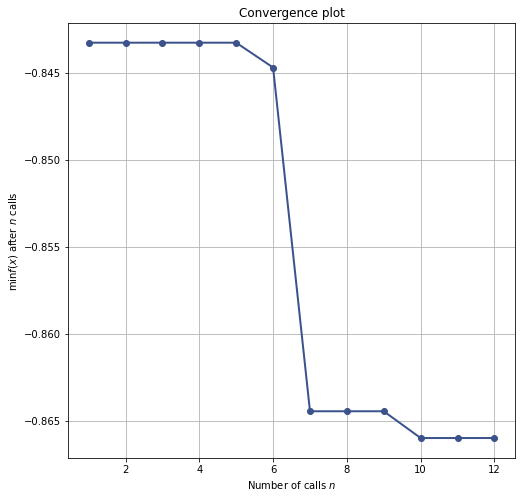

In [122]:
from skopt.plots import plot_convergence
plot_convergence(gp_result)

In [123]:
stacked_results = np.hstack(( np.array(gp_result.x_iters), np.expand_dims(np.array((-1)*gp_result.func_vals), axis=1) ))

In [124]:
pd.DataFrame(stacked_results, columns=["learning rate", "batch size", "optimizer", "decay rate", "decay steps", "f1-score"])

learning rate batch size optimizer          decay rate  \
0                   0.0001         16      Adam                   1   
1                    0.001         16      Adam                0.95   
2                   0.0001         16   RMSProp                   1   
3                    0.001         16   RMSProp                0.95   
4    9.999986351452042e-05         16      Adam                 1.0   
5    0.0001067154522464192         16      Adam  0.9974457892965298   
6   1.5288204723630643e-05          8   RMSProp  0.9830643739439201   
7    0.0001753374838025707          8   RMSProp  0.9866694177663523   
8                    1e-05         16      Adam                0.95   
9                    1e-05         16   RMSProp                0.95   
10  0.00023411056617977783          8      Adam                 1.0   
11                   1e-05          8   RMSProp                 1.0   

           decay steps              f1-score  
0                    3    0.8432818055152893  
1                    3   0.15083469450473785  
2                    3    0.1867770403623581  
3                    3  0.019912540912628174  
4                  3.0    0.8382734060287476  
5    2.489905266212059    0.8447087407112122  
6   1.6272916512885405    0.8644600510597229  
7    2.957236289477643   0.08399240672588348  
8                  1.0   0.13966552913188934  
9                  3.0    0.8659983277320862  
10                 3.0    0.8237815499305725  
11                 1.0    0.8573590517044067

Okay perfect! Now a good fit for the hyperparameters is found. Now the final model can finally be trained! <br> <br>
I like to train the final model for a certain fixed number of epochs, where always the best model according to the validation f1-score is stored. Another option is to use early stopping. But I'm personal not a fan of early stopping, because it could also stop too early when the amount of epochs without improvement is set too low.

## Final Model Training

In [150]:
encoder = "densenet121"
num_epochs = 50
target_size = (256, 256)

# create data generators in order to load the images
datagen_train = ImageDataGenerator(rescale=1./255,preprocessing_function=apply_augmentation)
datagen_val = ImageDataGenerator(rescale = 1. / 255)

train_generator = datagen_train.flow_from_dataframe(dataframe=df_train, directory=path_to_images,
                                                    x_col="filename", y_col=df_train.columns[2:], 
                                                    batch_size=batch_size, shuffle=shuffle,
                                                    class_mode="raw", target_size=target_size, 
                                                    color_mode="rgb", seed=42)

valid_generator = datagen_val.flow_from_dataframe(dataframe=df_val, directory=path_to_images,
                                                    x_col="filename", y_col=df_val.columns[2:], 
                                                    batch_size=batch_size, shuffle=shuffle,
                                                    class_mode="raw", target_size=target_size, 
                                                    color_mode="rgb", seed=42)

# set parameters for learning
steps_per_epoch_train = train_generator.__len__()
steps_per_epoch_val = valid_generator.__len__()

# get best parameters
learning_rate, batch_size, optimizer, decay_rate, decay_steps = gp_result.x

# create the callback for storing the best model
path_to_store = r"model\best_model_{epoch:02d}_{val_f1_score:.3f}"
save_bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=path_to_store, 
                                                           save_weights_only=False, 
                                                           verbose=1,
                                                           monitor="val_f1_score", 
                                                           save_best_only=True, 
                                                           mode="max")

# create model
model = create_model(learning_rate, optimizer, decay_rate, decay_steps, steps_per_epoch_train,
                     encoder, class_names)

history = model.fit(train_generator, epochs=num_epochs, verbose=1, validation_data=valid_generator,
                    callbacks=save_bestmodel_callback)

Found 6515 validated image filenames.
Found 1629 validated image filenames.
Epoch 1/50
408/408 [==============================] - 297s 697ms/step - loss: 5.3788 - categorical_accuracy: 0.0218 - auc: 0.5701 - f1_score: 1.3664e-04 - val_loss: 4.0853 - val_categorical_accuracy: 0.1529 - val_auc: 0.8561 - val_f1_score: 0.0053

Epoch 00001: val_f1_score improved from -inf to 0.00533, saving model to model\best_model_01_0.005
INFO:tensorflow:Assets written to: model\best_model_01_0.005\assets
Epoch 2/50
408/408 [==============================] - 220s 539ms/step - loss: 3.9272 - categorical_accuracy: 0.2017 - auc: 0.8789 - f1_score: 0.0097 - val_loss: 2.6824 - val_categorical_accuracy: 0.4064 - val_auc: 0.9638 - val_f1_score: 0.1037

Epoch 00002: val_f1_score improved from 0.00533 to 0.10372, saving model to model\best_model_02_0.104
INFO:tensorflow:Assets written to: model\best_model_02_0.104\assets
Epoch 3/50
408/408 [==============================] - 258s 632ms/step - loss: 2.8434 - catego

INFO:tensorflow:Assets written to: model\best_model_21_0.849\assets
Epoch 22/50
408/408 [==============================] - 228s 558ms/step - loss: 0.1619 - categorical_accuracy: 0.9651 - auc: 0.9993 - f1_score: 0.9609 - val_loss: 0.5102 - val_categorical_accuracy: 0.8607 - val_auc: 0.9947 - val_f1_score: 0.8479

Epoch 00022: val_f1_score did not improve from 0.84864
Epoch 23/50
408/408 [==============================] - 264s 645ms/step - loss: 0.1730 - categorical_accuracy: 0.9657 - auc: 0.9989 - f1_score: 0.9618 - val_loss: 0.5606 - val_categorical_accuracy: 0.8471 - val_auc: 0.9931 - val_f1_score: 0.8401

Epoch 00023: val_f1_score did not improve from 0.84864
Epoch 24/50
408/408 [==============================] - 269s 658ms/step - loss: 0.1460 - categorical_accuracy: 0.9683 - auc: 0.9997 - f1_score: 0.9650 - val_loss: 0.5555 - val_categorical_accuracy: 0.8508 - val_auc: 0.9937 - val_f1_score: 0.8405

Epoch 00024: val_f1_score did not improve from 0.84864
Epoch 25/50
408/408 [========

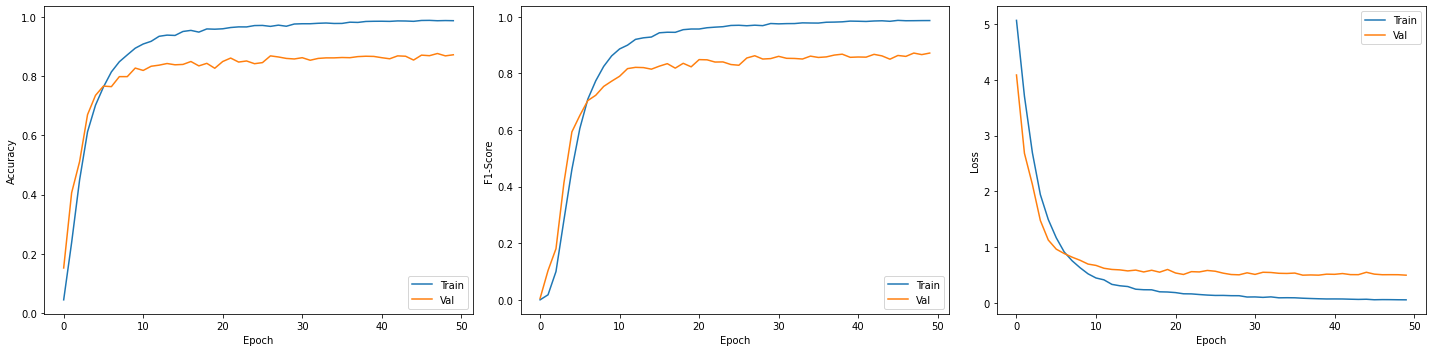

In [156]:
figpath = r"figures\final_model_results.pdf"
fig = plt.figure(figsize = (20, 5))
hist_dict = history.history
    
plt.subplot(1, 3, 1)
plt.plot(hist_dict["categorical_accuracy"], label="Train")
plt.plot(hist_dict["val_categorical_accuracy"], label="Val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

plt.subplot(1, 3, 2)
plt.plot(hist_dict["f1_score"], label="Train")
plt.plot(hist_dict["val_f1_score"], label="Val")
plt.xlabel("Epoch")
plt.ylabel("F1-Score")
plt.legend(loc="lower right")

plt.subplot(1, 3, 3)
plt.plot(hist_dict["loss"], label="Train")
plt.plot(hist_dict["val_loss"], label="Val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")

plt.tight_layout()
plt.savefig(figpath)
plt.show()

The best model was found in epoch 48 with a validation f1-score of 87.2 percentage.

In [157]:
# load best model
path = r"model\final_model"
final_model = tf.keras.models.load_model(path)

# set up test data pipeline
datagen_test = ImageDataGenerator(rescale = 1. / 255)
test_generator = datagen_test.flow_from_dataframe(dataframe=df_test, directory=path_to_images,
                                                    x_col="filename", y_col=df_test.columns[2:], 
                                                    batch_size=16, class_mode="raw", 
                                                    target_size=target_size, 
                                                    color_mode="rgb", seed=42)


# evaluate model on test set
test_results_dict = final_model.evaluate(x=test_generator, verbose=1, return_dict=True)

Found 8041 validated image filenames.
503/503 [==============================] - 217s 428ms/step - loss: 0.5174 - categorical_accuracy: 0.8625 - auc: 0.9886 - f1_score: 0.8696


Very nice! The trained final model achieves a f1-score of almost 87%! This shows that the model has learned the underlying task and data very well and performs good in the real world. Let's now plot some class activation maps in order to see what the model has learned.